# Cross validation of the Intravoxel incoherent motion (ivim) model in Dipy

We will use sklearn's `cross_val_score` which requires us to build an estimator with a `fit` and `predict` method defined. In order to use the sklearn machinery, we need to make our estimator inherit the BaseEstimator class. Refer to the documentation on [rolling your own estimator](http://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator).

## Ivim model

The IVIM model expresses the MRI signal as follows:

$$ S(b)=S_0(fe^{-bD^*}+(1-f)e^{-bD}) $$

where $\mathbf{b}$ is the diffusion gradient weighing value (which is dependent on the measurement parameters), $\mathbf{S_{0}}$ is the signal in the absence of diffusion gradient sensitization, $\mathbf{f}$ is the perfusion fraction, $\mathbf{D}$ is the diffusion coefficient and $\mathbf{D^*}$ is the pseudo-diffusion constant, due to vascular contributions.

We want to compare the performace of this model with other models such as a simple exponential decay.

The signal is recorded for many `b-values` at each point (voxel). Thus we have an array of signal values S(b) for each voxel. After we fit the data from each voxel and get the model parameters we would like to see how well the predictions match with the actual values. We will split our dataset to perform "leave-one-out cross validation" or "n-cross validation" by leaving out some voxels and predicting their signal values. The metric we use here is sklearn's `neg_mean_squared_error`.

In [1]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score, ShuffleSplit
from dipy.reconst.ivim import IvimModel
from dipy.data.fetcher import read_ivim
import matplotlib.pyplot as plt
% matplotlib inline

# Downloading the data and selecting a small slice for testing

The dataset supplied here is from Eric Peterson [share](https://figshare.com/articles/IVIM_dataset/3395704). It has MRI signal data for a 3D region (brain) where each voxel will have its own parameters (S0, f, D and D_star). Dipy has a `fetcher` to download the ivim data.

In [2]:
img, gtab = read_ivim()
data = img.get_data()

print('data.shape (%d, %d, %d, %d)' % data.shape)

Dataset is already in place. If you want to fetch it again please first remove the folder /Users/shahnawaz/.dipy/ivim 
data.shape (256, 256, 54, 21)


# Select a slice from the complete voxel data

We select a slice which is located 33 units in the z axis with an area marked by x1, x2, y1, y2. Setting `:` for the last index means that we consider data for all the bvalues.

In [3]:
z = 33
x1, x2 = 90, 150
y1, y2 = 90, 180

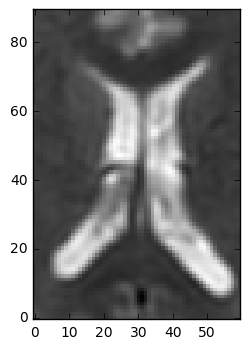

In [4]:
# Plot at b=0
b_val = 0
plt.imshow(data[x1:x2, y1:y2, z, b_val].T, origin='lower',
           cmap="gray", interpolation='nearest')
plt.show("CSF_slice.png")
plt.close()

# Initializing the `IvimModel` and performing a fit

In [5]:
# Initialize the ivim model
ivimmodel = IvimModel(gtab)
data_slice = data[90:100, 90:100, z, :]
ivimfit = ivimmodel.fit(data_slice)

# Display model parameters 
print(ivimfit.model_params[0])

[[  5.30546614e+03   3.00000000e-01   2.72910411e-03   6.62322438e-04]
 [  5.37174322e+03   3.00000000e-01   2.78922393e-03   6.87788811e-04]
 [  5.18012061e+03   3.00000000e-01   2.62790991e-03   6.85006231e-04]
 [  4.83387718e+03   3.00000000e-01   2.08925016e-03   6.80651494e-04]
 [  4.53160381e+03   3.00000000e-01   1.51359061e-03   7.03756518e-04]
 [  4.38689830e+03   3.00000000e-01   1.55291628e-03   6.41886453e-04]
 [  4.37793014e+03   3.00000000e-01   2.05200892e-03   5.41403036e-04]
 [  4.35485598e+03   3.00000000e-01   2.17139860e-03   5.15077200e-04]
 [  4.28023285e+03   3.00000000e-01   1.94778943e-03   5.21662490e-04]
 [  4.27726212e+03   3.00000000e-01   2.04820770e-03   4.85247323e-04]]


/Users/shahnawaz/dev/dipy/dipy/reconst/ivim.py:404: UserWarning: x0 obtained from linear fitting is not feasibile as initial guess for leastsq while estimating f and D_star. Using parameters from the linear fit.
  warnings.warn(warningMsg, UserWarning)
/Users/shahnawaz/dev/dipy/dipy/reconst/ivim.py:498: UserWarning: x0 is unfeasible for leastsq fitting. Returning x0 values from the linear fit.
  warnings.warn(warningMsg, UserWarning)
/Users/shahnawaz/dev/dipy/dipy/reconst/ivim.py:293: UserWarning: Bounds are violated for leastsq fitting. Returning parameters from linear fit
  warnings.warn(warningMsg, UserWarning)


# Making your own estimator

We wish to use the `IvimModel` for cross validation and will build our custom sklearn estimator with it. But first let us build a simple estimator which predicts parameters for an exponential decay model.

$$ y = S_{0} e^{-D x}$$

In [7]:
class ExponentialCrossVal(BaseEstimator):
    """
    A custom estimator which can be used with sklearn's `cross_val_score`
    """
    def __init__(self, params=None):
        self.params = params
        
    def fit(self, X, y):
        """
        We will fit an exponential model using a logarithmic transformation
        and using the `polyfit` function from numpy.
        """
        D, neg_log_S0 = np.polyfit(X, -np.log(y), 1)
        S0 = np.exp(-neg_log_S0)
        self.params = [S0, D]
        
    def predict(self, X):
        """
        Predict the values of the signal after fitting using the model params.
        """
        return self.params[0] * np.exp(-X * self.params[1])

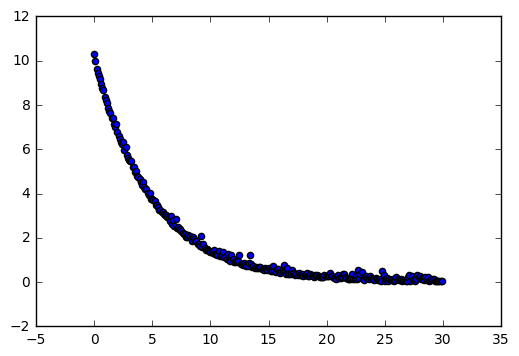

In [37]:
X_train = np.array([x/10. for x in range(300)])
# Set S0 and D
S0 = 10.
D = 0.2
y = S0 * np.exp(- D * X_train)
# Add some noise to the data. Change the scale to tune the noise.
y_train = [val + np.random.exponential(scale=0.09) for val in y]

# Plot
plt.scatter(X_train, y_train)
plt.show()

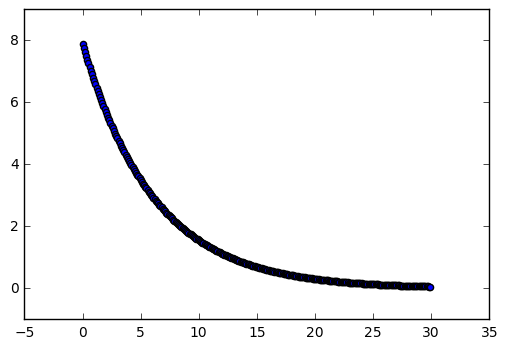

In [38]:
model = ExponentialCrossVal()
model.fit(X_train, y_train)
prediction = model.predict(X_train)

plt.scatter(X_train, prediction)
plt.show()

# Calculate the cross validation scores

We will consider the metric `neg_mean_squared_error`. For k cross validation, we will shuffle the input data using `ShuffleSplit`.

In [39]:
cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
print (cross_val_score(ExponentialCrossVal(), X_train, y, scoring = 'neg_mean_squared_error', cv = cv))

[ -6.39232144e-30  -5.36814560e-30  -8.20026598e-31]


### As you can see that the errors are very less. That is because we are passing a dataset which is that of an exponential decay. But what if we pass data which is a linear decay.

# Consider the scores from a linear dataset

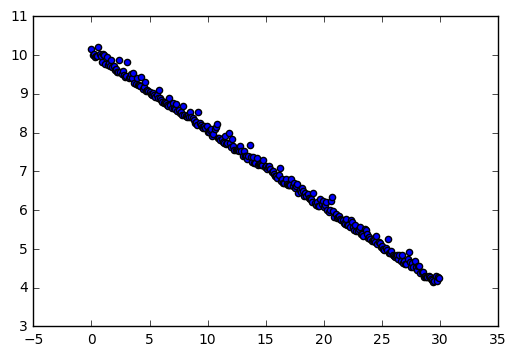

In [43]:
y = S0 -D * X_train
# Add some noise to the data. Change the scale to tune the noise.
y_train = [val + np.random.exponential(scale=0.09) for val in y]

# Plot
plt.scatter(X_train, y_train)
plt.show()

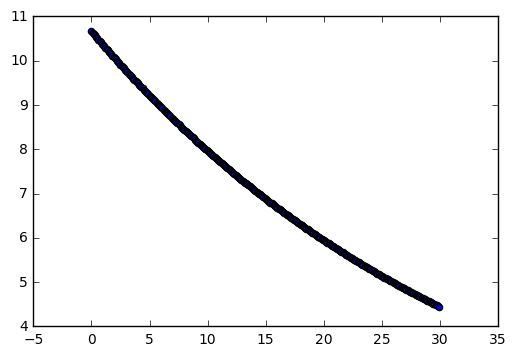

In [48]:
model = ExponentialCrossVal()
model.fit(X_train, y_train)
prediction = model.predict(X_train)

plt.scatter(X_train, prediction)
plt.show()

In [49]:
cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
print (cross_val_score(ExponentialCrossVal(), X_train, y, scoring = 'neg_mean_squared_error', cv = cv))

[-0.04109578 -0.0545822  -0.0382194 ]


### Thus this model is not fit for the linear dataset. Let us now consider a new model `LinearCrossVal`

In [57]:
class LinearCrossVal(BaseEstimator):
    """
    A custom estimator which can be used with sklearn's `cross_val_score`
    """
    def __init__(self, params=None):
        self.params = params
        
    def fit(self, X, y):
        """
        We will fit a linear model using the `polyfit` function from numpy.
        """
        D, S0 = np.polyfit(X, y, 1)
        self.params = [S0, D]
        
    def predict(self, X):
        """
        Predict the values of the signal after fitting using the model params.
        """
        return self.params[0] + X * self.params[1]

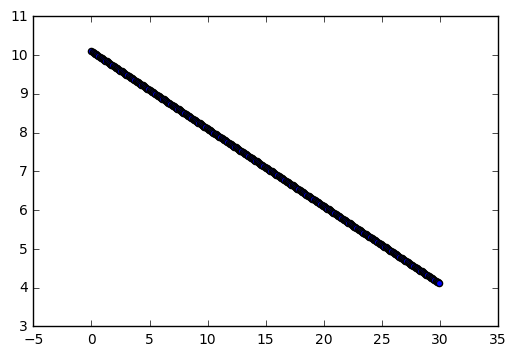

In [58]:
linear_model = LinearCrossVal()
linear_model.fit(X_train, y_train)
linear_prediction = linear_model.predict(X_train)

plt.scatter(X_train, linear_prediction)
plt.show()

In [59]:
cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
print (cross_val_score(LinearCrossVal(), X_train, y, scoring = 'neg_mean_squared_error', cv = cv))

[ -6.60013624e-30  -3.76023698e-30  -3.96183477e-30]


### As expected, the cross validation using the linear model yields much less error